In [64]:
import numpy as np
import pandas as pd
from pandas import read_table
import seaborn as sns 
import re
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib.colors import ListedColormap
import itertools
 
from sklearn.decomposition import PCA as PCA
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold

%matplotlib inline
plt.style.use('ggplot')

In [2]:
import keras
from keras.utils.np_utils import to_categorical
#from keras.layers import Conv2D, MaxPooling1D, GlobalAveragePooling1D
#from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.callbacks import ModelCheckpoint 

C:\Users\joyjs\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [112]:
#np.random.seed(42)  
#PYTHONHASHSEED = 0

In [3]:
#import pydot
#from mlxtend.plotting import plot_confusion_matrix
#pydot.find_graphviz = lambda: True

In [4]:
#import graphviz

#### 0. Dataframe Construction

In [3]:
with open('data/features.txt', 'r') as f:
    features = [x.strip() for x in f]
features

['tBodyAcc-Mean-1',
 'tBodyAcc-Mean-2',
 'tBodyAcc-Mean-3',
 'tBodyAcc-STD-1',
 'tBodyAcc-STD-2',
 'tBodyAcc-STD-3',
 'tBodyAcc-Mad-1',
 'tBodyAcc-Mad-2',
 'tBodyAcc-Mad-3',
 'tBodyAcc-Max-1',
 'tBodyAcc-Max-2',
 'tBodyAcc-Max-3',
 'tBodyAcc-Min-1',
 'tBodyAcc-Min-2',
 'tBodyAcc-Min-3',
 'tBodyAcc-SMA-1',
 'tBodyAcc-Energy-1',
 'tBodyAcc-Energy-2',
 'tBodyAcc-Energy-3',
 'tBodyAcc-IQR-1',
 'tBodyAcc-IQR-2',
 'tBodyAcc-IQR-3',
 'tBodyAcc-ropy-1',
 'tBodyAcc-ropy-1',
 'tBodyAcc-ropy-1',
 'tBodyAcc-ARCoeff-1',
 'tBodyAcc-ARCoeff-2',
 'tBodyAcc-ARCoeff-3',
 'tBodyAcc-ARCoeff-4',
 'tBodyAcc-ARCoeff-5',
 'tBodyAcc-ARCoeff-6',
 'tBodyAcc-ARCoeff-7',
 'tBodyAcc-ARCoeff-8',
 'tBodyAcc-ARCoeff-9',
 'tBodyAcc-ARCoeff-10',
 'tBodyAcc-ARCoeff-11',
 'tBodyAcc-ARCoeff-12',
 'tBodyAcc-Correlation-1',
 'tBodyAcc-Correlation-2',
 'tBodyAcc-Correlation-3',
 'tGravityAcc-Mean-1',
 'tGravityAcc-Mean-2',
 'tGravityAcc-Mean-3',
 'tGravityAcc-STD-1',
 'tGravityAcc-STD-2',
 'tGravityAcc-STD-3',
 'tGravityAcc-M

In [4]:
X_train = pd.read_csv('data/X_train.txt', header = None, delim_whitespace = True)
y_train = pd.read_csv('data/y_train.txt', header = None)
X_test = pd.read_csv('data/X_test.txt', header = None, delim_whitespace = True)
y_test = pd.read_csv('data/y_test.txt', header = None)

In [5]:
X_train.columns = features
X_test.columns = features
X_train.shape

(7767, 561)

In [6]:
y_train.columns = ['activity']
y_test.columns = ['activity']
y_train.head(3)
y_train.shape

(7767, 1)

In [7]:
activity_map = {1:'WALKING',
                2:'WALKING_UPSTAIRS',
                3:'WALKING_DOWNSTAIRS',
                4:'SITTING',
                5:'STANDING',
                6:'LAYING',
                7:'STAND_TO_SIT',
                8:'SIT_TO_STAND',
                9:'SIT_TO_LIE',
                10:'LIE_TO_SIT',
                11:'STAND_TO_LIE',
                12:'LIE_TO_STAND'}

In [8]:
y_train = y_train.replace({'activity':activity_map})
y_test = y_test.replace({'activity':activity_map})

In [9]:
activity, counts = np.unique(y_train.activity, return_counts=True)

In [10]:
print(activity,counts)

['LAYING' 'LIE_TO_SIT' 'LIE_TO_STAND' 'SITTING' 'SIT_TO_LIE'
 'SIT_TO_STAND' 'STANDING' 'STAND_TO_LIE' 'STAND_TO_SIT' 'WALKING'
 'WALKING_DOWNSTAIRS' 'WALKING_UPSTAIRS'] [1413   60   57 1293   75   23 1423   90   47 1226  987 1073]


#### 1. Exploratory Analysis 

In [11]:
print('There are {} samples in total; {} in training set and {} in testing set'.format((len(X_train)+len(X_test)),len(X_train), len(X_test)))

There are 10929 samples in total; 7767 in training set and 3162 in testing set


In [12]:
'''activity, counts = np.unique(y_train.activity, return_counts=True)

plt.figure(figsize=(10, 4))

plt.bar(activity, counts, color = 'lightblue')
plt.suptitle('Class Imbalance', fontsize=16)
plt.xticks([(x-0.5) for x in range(len(counts) + 1)], rotation=90, fontsize=8)
plt.xlim([0, 12])
plt.ylabel('frequency', fontsize=10)


plt.show()'''

"activity, counts = np.unique(y_train.activity, return_counts=True)\n\nplt.figure(figsize=(10, 4))\n\nplt.bar(activity, counts, color = 'lightblue')\nplt.suptitle('Class Imbalance', fontsize=16)\nplt.xticks([(x-0.5) for x in range(len(counts) + 1)], rotation=90, fontsize=8)\nplt.xlim([0, 12])\nplt.ylabel('frequency', fontsize=10)\n\n\nplt.show()"

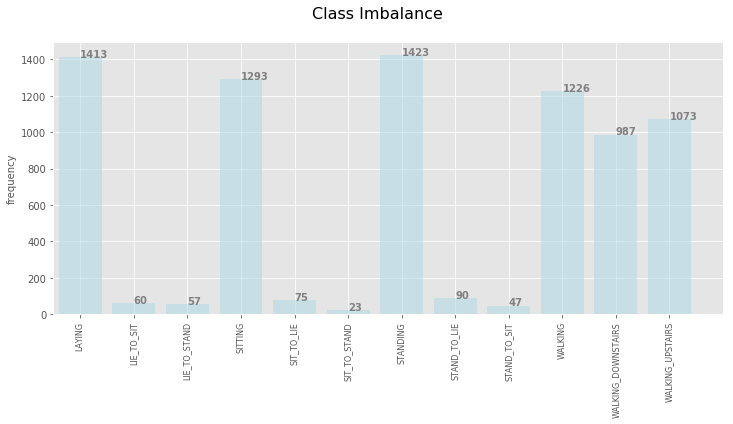

In [13]:
label =['LAYING', 'LIE_TO_SIT', 'LIE_TO_STAND', 'SITTING', 'SIT_TO_LIE',
 'SIT_TO_STAND', 'STANDING', 'STAND_TO_LIE', 'STAND_TO_SIT', 'WALKING',
 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']

frq =[1413,60,57,1293,75,23,1423,90,47,1226,987,1073]
index = np.arange(len(label))

plt.figure(figsize=(12, 5))

plt.bar(index, frq, align = 'center', alpha = 0.5, color = 'lightblue')

plt.suptitle('Class Imbalance', fontsize=16)

plt.xticks(index, label, rotation=90, fontsize=8)
plt.xlim([-.5, 12])
plt.ylabel('frequency', fontsize=10)

for i, v in enumerate(frq):
    plt.text(i, v, str(v), color='grey', fontweight='bold')

plt.show()

In [14]:
X_train['activity'] = y_train

In [15]:
activity, counts = np.unique(y_train.activity, return_counts=True)

In [16]:
X_train.head(3)

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,fBodyGyroJerkMag-Skewness-1,fBodyGyroJerkMag-Kurtosis-1,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,activity
0,0.043580,-0.005970,-0.035054,-0.995381,-0.988366,-0.937382,-0.995007,-0.988816,-0.953325,-0.794796,...,-0.314848,-0.713308,-0.112754,0.030400,-0.464761,-0.018446,-0.841559,0.179913,-0.051718,STANDING
1,0.039480,-0.002131,-0.029067,-0.998348,-0.982945,-0.971273,-0.998702,-0.983315,-0.974000,-0.802537,...,-0.603199,-0.860677,0.053477,-0.007435,-0.732626,0.703511,-0.845092,0.180261,-0.047436,STANDING
2,0.039978,-0.005153,-0.022651,-0.995482,-0.977314,-0.984760,-0.996415,-0.975835,-0.985973,-0.798477,...,-0.404427,-0.761847,-0.118559,0.177899,0.100699,0.808529,-0.849230,0.180610,-0.042271,STANDING


In [42]:
model = ExtraTreesClassifier(n_estimators=250,
                             random_state=0)
model.fit(X_train_pca, y_train_org.values.ravel())
importances = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train_pca.shape[1]):
    print("%d. feature %d (%f)" %(f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 56 (0.031462)
2. feature 52 (0.029561)
3. feature 40 (0.027234)
4. feature 41 (0.022124)
5. feature 558 (0.021163)
6. feature 50 (0.020511)
7. feature 49 (0.018583)
8. feature 559 (0.018434)
9. feature 53 (0.018319)
10. feature 57 (0.013945)
11. feature 58 (0.008204)
12. feature 42 (0.008089)
13. feature 51 (0.007641)
14. feature 9 (0.007500)
15. feature 54 (0.007052)
16. feature 77 (0.006724)
17. feature 560 (0.006589)
18. feature 504 (0.006189)
19. feature 3 (0.005861)
20. feature 201 (0.005736)
21. feature 271 (0.005720)
22. feature 507 (0.005341)
23. feature 445 (0.005289)
24. feature 268 (0.005242)
25. feature 508 (0.004865)
26. feature 314 (0.004818)
27. feature 310 (0.004817)
28. feature 502 (0.004716)
29. feature 63 (0.004640)
30. feature 86 (0.004614)
31. feature 37 (0.004508)
32. feature 6 (0.004498)
33. feature 517 (0.004464)
34. feature 302 (0.004462)
35. feature 214 (0.004268)
36. feature 69 (0.004244)
37. feature 73 (0.004227)
38. feature 55 (0

In [18]:
important_features =[features[56],features[52],features[40],features[41],features[558]]
important_features

['tGravityAcc-Energy-1',
 'tGravityAcc-Min-1',
 'tGravityAcc-Mean-1',
 'tGravityAcc-Mean-2',
 'tXAxisAcc-AngleWRTGravity-1']

In [19]:
'''act_grp = X_train.groupby('activity')
plt.figure(figsize=(10, 10))

for name, group in act_grp:
    fig, axes = plt.subplots(nrows = 1, ncols = 1)
    fig.set_size_inches(10,7.55)
    plt.plot(group['tBodyAcc-Mean-1'],'.', label=name)
    plt.plot(group['tBodyAcc-Mean-2'],'.', label=name)
    plt.plot(group['tBodyAcc-Mean-3'],'.', label=name)
    plt.plot(group['tGravityAcc-Mean-1'],'.', label=name)
    plt.plot(group['tGravityAcc-Mean-2'],'.', label=name)
    plt.plot(group['tGravityAcc-Mean-3'],'.', label=name)

plt.legend(loc='best')
plt.show()
'''

"act_grp = X_train.groupby('activity')\nplt.figure(figsize=(10, 10))\n\nfor name, group in act_grp:\n    fig, axes = plt.subplots(nrows = 1, ncols = 1)\n    fig.set_size_inches(10,7.55)\n    plt.plot(group['tBodyAcc-Mean-1'],'.', label=name)\n    plt.plot(group['tBodyAcc-Mean-2'],'.', label=name)\n    plt.plot(group['tBodyAcc-Mean-3'],'.', label=name)\n    plt.plot(group['tGravityAcc-Mean-1'],'.', label=name)\n    plt.plot(group['tGravityAcc-Mean-2'],'.', label=name)\n    plt.plot(group['tGravityAcc-Mean-3'],'.', label=name)\n\nplt.legend(loc='best')\nplt.show()\n"

In [20]:
def plot_features_activity(features,title, sharex = True, sharey = True):
    fig, axes = plt.subplots(nrows = 6, ncols = 2)
    fig.set_size_inches(20,15)
    plt.suptitle(title, fontsize=20)
    
    x_loc = 0 
    y_loc = 0 
    
    for activity in np.unique(y_train):
        X_train[X_train['activity'] == activity][features].plot( use_index = False, ax = axes[y_loc, x_loc])
        axes[y_loc, x_loc].set_title(activity)

        if x_loc < 1: 
            x_loc += 1
        else:
            x_loc = 0
            y_loc += 1
            
title = 'Distribution of the Top 5 Important Features per Activity'

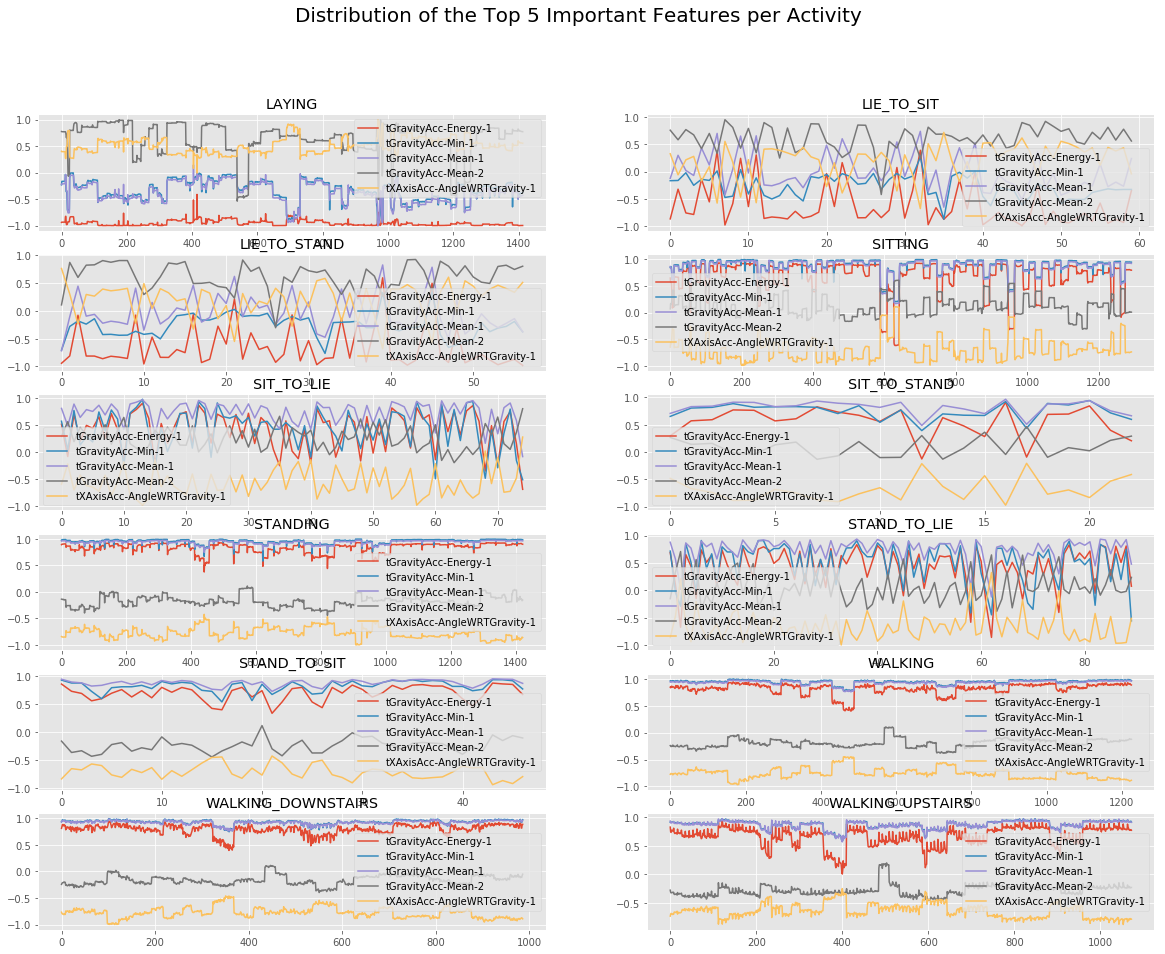

In [21]:
#features = ['tBodyAcc-Mean-1', 'tBodyAcc-Mean-2', 'tBodyAcc-Mean-3']
plot_features_activity(important_features, title)

In [23]:
'''features = ['tGravityAcc-Mean-1',
 'tGravityAcc-Mean-2',
 'tGravityAcc-Mean-3']
plot_features_activity(features)'''

"features = ['tGravityAcc-Mean-1',\n 'tGravityAcc-Mean-2',\n 'tGravityAcc-Mean-3']\nplot_features_activity(features)"

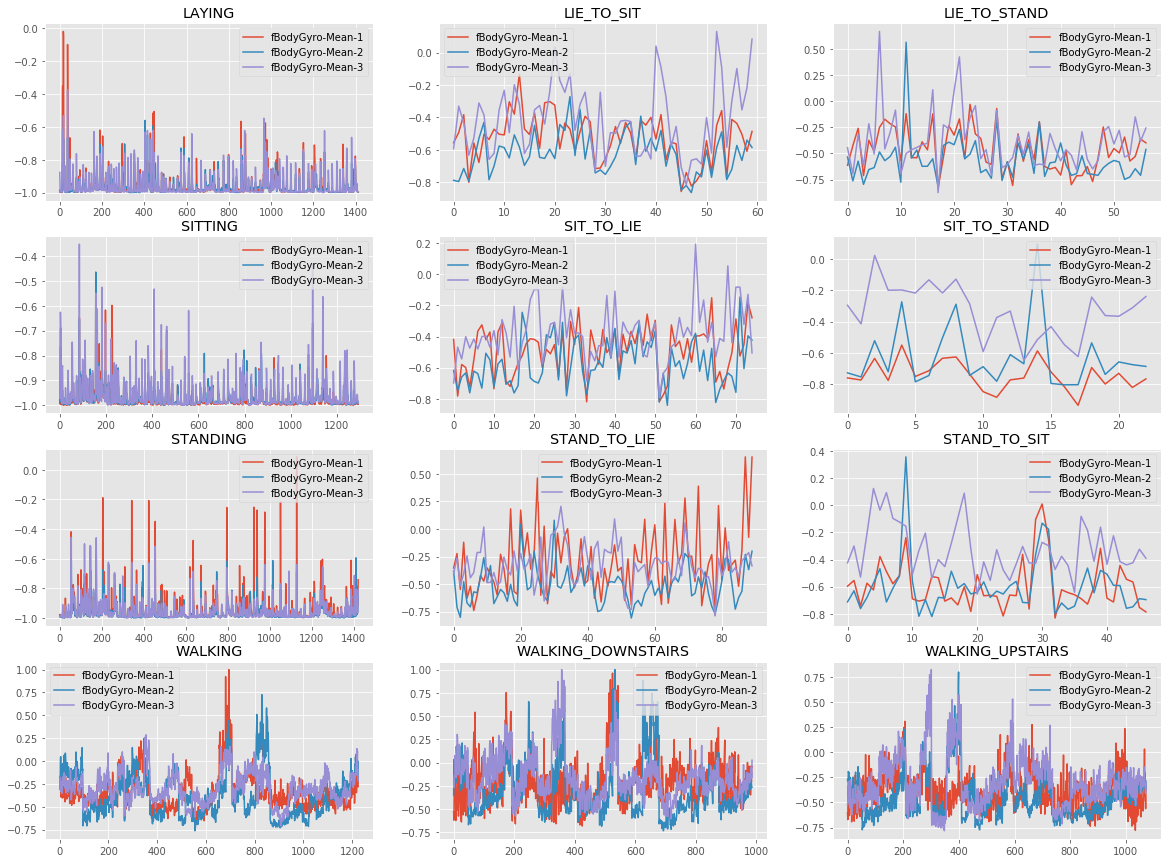

In [23]:
features = ['fBodyGyro-Mean-1',
 'fBodyGyro-Mean-2',
 'fBodyGyro-Mean-3']
plot_features_activity(features)

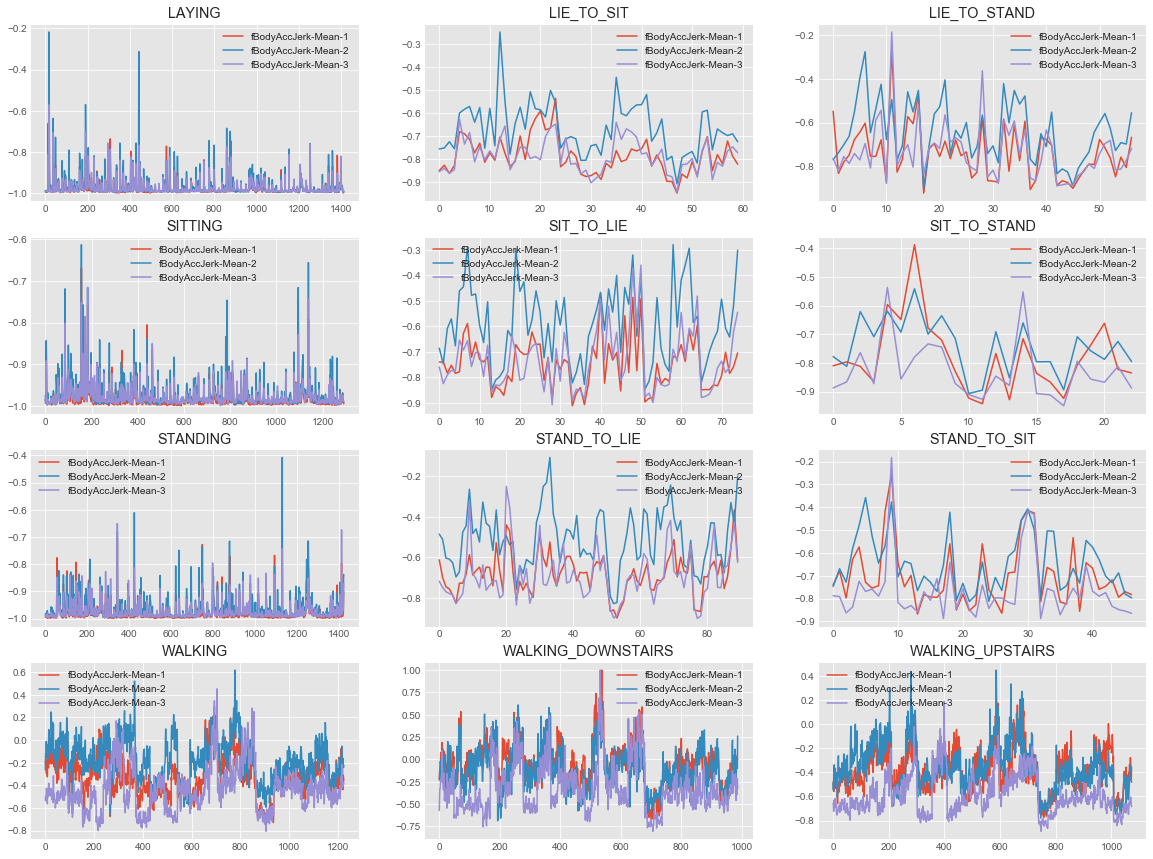

In [182]:
features = [ 'fBodyAccJerk-Mean-1',
 'fBodyAccJerk-Mean-2',
 'fBodyAccJerk-Mean-3']
plot_features_activity(features)

#### 2. Deep Dive Analysis
##### 2.1 Using PCA for Dimension Reduction

In [24]:
X_train_pca = X_train.drop(['activity'], axis=1)

In [26]:
pca = PCA(n_components = X_train_pca.shape[1])
pca.fit_transform(X_train_pca)
print(pca.explained_variance_ratio_)

[5.86355935e-01 6.42561212e-02 4.48901660e-02 2.11690519e-02
 1.63638307e-02 1.36350383e-02 1.25166356e-02 1.15889160e-02
 9.98505793e-03 9.10734517e-03 8.09029680e-03 7.40391401e-03
 7.07084375e-03 5.87645503e-03 5.34970429e-03 5.12337016e-03
 4.87139890e-03 4.76667150e-03 4.43129001e-03 4.28026845e-03
 4.17815548e-03 4.09160485e-03 3.98404234e-03 3.73090612e-03
 3.51524180e-03 3.33683821e-03 3.08829993e-03 2.98561051e-03
 2.91886511e-03 2.88599729e-03 2.81267841e-03 2.69892723e-03
 2.60403262e-03 2.53542846e-03 2.49707439e-03 2.44550297e-03
 2.38899037e-03 2.25486622e-03 2.23000882e-03 2.18135405e-03
 2.07603263e-03 2.00066726e-03 1.93093871e-03 1.91521422e-03
 1.84602729e-03 1.78786050e-03 1.76734813e-03 1.67369126e-03
 1.63538267e-03 1.59482234e-03 1.53670362e-03 1.53077188e-03
 1.49521662e-03 1.47542272e-03 1.41333944e-03 1.33711354e-03
 1.32960673e-03 1.26424167e-03 1.23429775e-03 1.21195036e-03
 1.19747609e-03 1.15048453e-03 1.12728626e-03 1.11797043e-03
 1.08985516e-03 1.063317

In [27]:
pca100 = PCA(n_components = 100)
pca100.fit_transform(X_train_pca)
print(pca100.explained_variance_ratio_)

[5.86355935e-01 6.42561212e-02 4.48901660e-02 2.11690519e-02
 1.63638307e-02 1.36350383e-02 1.25166356e-02 1.15889160e-02
 9.98505793e-03 9.10734517e-03 8.09029680e-03 7.40391401e-03
 7.07084375e-03 5.87645503e-03 5.34970429e-03 5.12337016e-03
 4.87139890e-03 4.76667150e-03 4.43129001e-03 4.28026844e-03
 4.17815548e-03 4.09160484e-03 3.98404233e-03 3.73090609e-03
 3.51524178e-03 3.33683811e-03 3.08829988e-03 2.98561041e-03
 2.91886487e-03 2.88599713e-03 2.81267818e-03 2.69892668e-03
 2.60403245e-03 2.53542788e-03 2.49707355e-03 2.44550150e-03
 2.38899004e-03 2.25486553e-03 2.23000719e-03 2.18135308e-03
 2.07603035e-03 2.00066645e-03 1.93093352e-03 1.91521143e-03
 1.84602572e-03 1.78785019e-03 1.76734507e-03 1.67368061e-03
 1.63534885e-03 1.59480280e-03 1.53669185e-03 1.53076070e-03
 1.49520475e-03 1.47540004e-03 1.41330062e-03 1.33703617e-03
 1.32951754e-03 1.26418450e-03 1.23414403e-03 1.21188241e-03
 1.19723718e-03 1.15017059e-03 1.12698273e-03 1.11750665e-03
 1.08976459e-03 1.062888

In [28]:
def scree_plot(pca):
    
    vals = pca.explained_variance_ratio_*100
    plt.figure(figsize=(10, 7))
    cum_var = np.cumsum(vals)
    ax = plt.subplot(111)

    ax.plot(range(len(vals) + 1), np.insert(cum_var, 0, 0), color = 'lightblue', marker = '*')
    ax.bar(range(len(vals)), vals, alpha = 0.8)
    
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained (%)", fontsize=12)

    plt.title("Scree Plot", fontsize=12)
    plt.show()

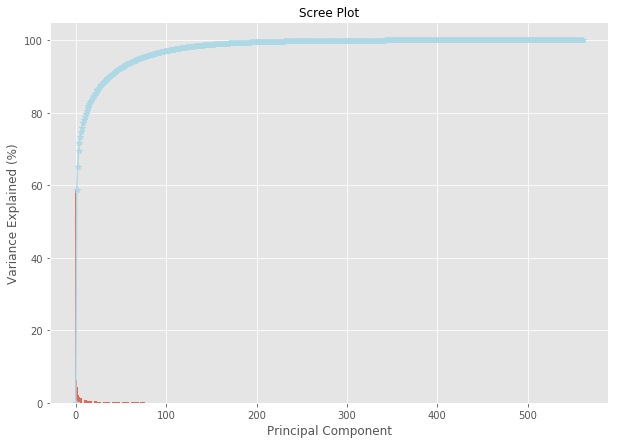

In [29]:
scree_plot(pca)

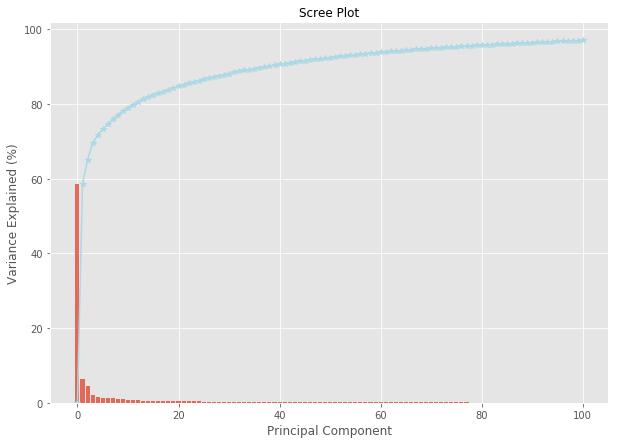

In [30]:
scree_plot(pca100)

In [31]:
acum_pca = 0
for i in range(pca.n_components_):
    acum_pca += pca.explained_variance_ratio_[i]
    table = "| {0} |  {1:0.2%} |".format(int(i+1),acum_pca)
    print(table)

| 1 |  58.64% |
| 2 |  65.06% |
| 3 |  69.55% |
| 4 |  71.67% |
| 5 |  73.30% |
| 6 |  74.67% |
| 7 |  75.92% |
| 8 |  77.08% |
| 9 |  78.08% |
| 10 |  78.99% |
| 11 |  79.80% |
| 12 |  80.54% |
| 13 |  81.24% |
| 14 |  81.83% |
| 15 |  82.37% |
| 16 |  82.88% |
| 17 |  83.37% |
| 18 |  83.84% |
| 19 |  84.29% |
| 20 |  84.71% |
| 21 |  85.13% |
| 22 |  85.54% |
| 23 |  85.94% |
| 24 |  86.31% |
| 25 |  86.66% |
| 26 |  87.00% |
| 27 |  87.31% |
| 28 |  87.60% |
| 29 |  87.90% |
| 30 |  88.18% |
| 31 |  88.47% |
| 32 |  88.74% |
| 33 |  89.00% |
| 34 |  89.25% |
| 35 |  89.50% |
| 36 |  89.74% |
| 37 |  89.98% |
| 38 |  90.21% |
| 39 |  90.43% |
| 40 |  90.65% |
| 41 |  90.86% |
| 42 |  91.06% |
| 43 |  91.25% |
| 44 |  91.44% |
| 45 |  91.63% |
| 46 |  91.81% |
| 47 |  91.98% |
| 48 |  92.15% |
| 49 |  92.31% |
| 50 |  92.47% |
| 51 |  92.63% |
| 52 |  92.78% |
| 53 |  92.93% |
| 54 |  93.08% |
| 55 |  93.22% |
| 56 |  93.35% |
| 57 |  93.48% |
| 58 |  93.61% |
| 59 |  93.73% |
| 60 |

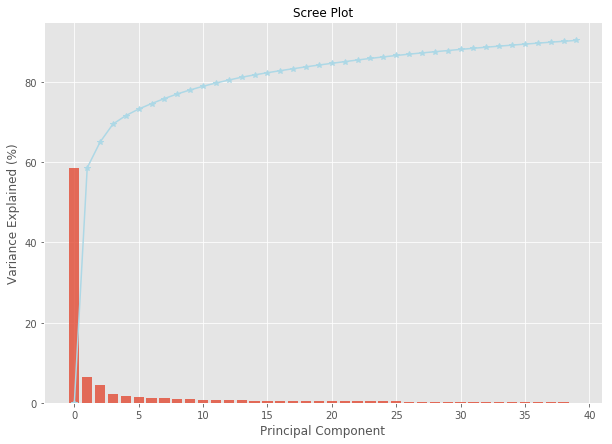

In [32]:
pca39 = PCA(n_components = 39)
X_train_pca39 = pca39.fit_transform(X_train_pca)
scree_plot(pca39)

In [33]:
X_test_pca39 = pca39.fit_transform(X_test)

In [34]:
pca160 = PCA(n_components = 160)
X_train_pca160 = pca160.fit_transform(X_train_pca)
X_test_pca160 = pca160.fit_transform(X_test)

In [35]:
pca3 = PCA(n_components = 3)
X_train_pca3 = pca3.fit_transform(X_train_pca)
X_test_pca3 = pca3.fit_transform(X_test)

##### 2.2 Comparing Classifiers

In [40]:
classifiers = [GaussianNB(), SVC(), RFC(), GBC(), KNC(12)]
model = []
acc_score  = []
roc_auc_score = []

for clf in classifiers: 
    
    clf = clf.fit(X_train_pca, y_train.values.ravel())
    pred = clf.predict(X_test)
    
    model.append(clf.__class__.__name__)
    acc_score.append(accuracy_score(pred, y_test))
    

acc_df = pd.DataFrame({'Model Used': model, 'Accuracy_Scores': acc_score})
acc_df

,Accuracy_Scores,Model Used
0,0.747312,GaussianNB
1,0.918406,SVC
2,0.892473,RandomForestClassifier
3,0.919355,GradientBoostingClassifier
4,0.885515,KNeighborsClassifier


In [39]:
'''classifiers = [GaussianNB(), SVC(), RFC(), GBC(), KNC(12)]
model = []
acc_score  = []

for clf in classifiers: 
    
    clf = clf.fit(X_train_pca39, y_train.values.ravel())
    pred = clf.predict(X_test_pca39)
    
    model.append(clf.__class__.__name__)
    acc_score.append(accuracy_score(pred, y_test))

acc_df = pd.DataFrame({'Model Used': model, 'Accuracy_Scores': acc_score})
acc_df'''

"classifiers = [GaussianNB(), SVC(), RFC(), GBC(), KNC(12)]\nmodel = []\nacc_score  = []\n\nfor clf in classifiers: \n    \n    clf = clf.fit(X_train_pca39, y_train.values.ravel())\n    pred = clf.predict(X_test_pca39)\n    \n    model.append(clf.__class__.__name__)\n    acc_score.append(accuracy_score(pred, y_test))\n\nacc_df = pd.DataFrame({'Model Used': model, 'Accuracy_Scores': acc_score})\nacc_df"

In [36]:
classifiers = [GaussianNB(), SVC(), RFC(), GBC(), KNC(12)]
model = []
acc_score  = []

for clf in classifiers: 
    
    clf = clf.fit(X_train_pca160, y_train.values.ravel())
    pred = clf.predict(X_test_pca160)
    
    model.append(clf.__class__.__name__)
    acc_score.append(accuracy_score(pred, y_test))

acc_df = pd.DataFrame({'Model Used': model, 'Accuracy_Scores': acc_score})
acc_df

,Accuracy_Scores,Model Used
0,0.630297,GaussianNB
1,0.640734,SVC
2,0.586970,RandomForestClassifier
3,0.632827,GradientBoostingClassifier
4,0.646426,KNeighborsClassifier


In [37]:
classifiers = [GaussianNB(), SVC(), RFC(), GBC(), KNC(12)]
model = []
acc_score  = []

for clf in classifiers: 
    
    clf = clf.fit(X_train_pca3, y_train.values.ravel())
    pred = clf.predict(X_test_pca3)
    
    model.append(clf.__class__.__name__)
    acc_score.append(accuracy_score(pred, y_test))

acc_df = pd.DataFrame({'Model Used': model, 'Accuracy_Scores': acc_score})
acc_df

,Accuracy_Scores,Model Used
0,0.710310,GaussianNB
1,0.735294,SVC
2,0.695130,RandomForestClassifier
3,0.712524,GradientBoostingClassifier
4,0.710310,KNeighborsClassifier


#### 2.3 Finding the Suitable Number of PCA 

In [84]:
n_components = range(3, 561, 25)
svc_train_acc_idx = []
svc_test_acc_idx = []

for number in n_components: 
    pca = PCA(n_components = number, whiten = True)
    pca.fit(X_train_pca)
    
    clf = SVC()
    clf.fit(pca.transform(X_train_pca), y_train.values.ravel())
    
    svc_train_pred = clf.predict(pca.transform(X_train_pca))
    svc_train_acc = accuracy_score(y_train.values.ravel(), svc_train_pred)
    svc_train_acc_idx.append(svc_train_acc)

    svc_test_pred = clf.predict(pca.transform(X_test))
    svc_test_acc = accuracy_score(y_test.values.ravel(), svc_test_pred)
    svc_test_acc_idx.append(svc_test_acc)
    
    print(svc_test_acc_idx)


[0.7602783048703352]
[0.7602783048703352, 0.9130297280202404]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701, 0.941808981657179]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701, 0.941808981657179, 0.9405439595192916]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701, 0.941808981657179, 0.9405439595192916, 0.931056293485136]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701, 0.941808981657179, 0.9405439595192916, 0.931056293485136, 0.9206198608475649]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701, 0.941808981657179, 0.9405439595192916, 0.931056293485136, 0.9206198608475649, 0.9187223276407337]
[0.7602783048703352, 0.9130297280202404, 0.9282099936748893, 0.9351676154332701, 0.941808981657179,

In [85]:
#print(svc_test_acc_idx)
#svc_max_n = n_components[test_acc_idx.index(max(test_acc_idx))]

#print(svc_max_n)

svc_max_n = n_components[np.argmax(svc_test_acc_idx)]
print(svc_max_n)



103


In [87]:
n_components = range(3, 561, 25)
gbc_train_acc_idx = []
gbc_test_acc_idx = []

for number in n_components: 
    pca = PCA(n_components = number, whiten = True)
    pca.fit(X_train_pca)
    
    clf = GBC()
    clf.fit(pca.transform(X_train_pca), y_train.values.ravel())
    
    gbc_train_pred = clf.predict(pca.transform(X_train_pca))
    gbc_train_acc = accuracy_score(y_train.values.ravel(), gbc_train_pred)
    gbc_train_acc_idx.append(gbc_train_acc)

    gbc_test_pred = clf.predict(pca.transform(X_test))
    gbc_test_acc = accuracy_score(y_test.values.ravel(), gbc_test_pred)
    gbc_test_acc_idx.append(gbc_test_acc)
    
    print(gbc_test_acc_idx)


[0.7308665401644528]
[0.7308665401644528, 0.8738140417457305]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699, 0.8934218848829855]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699, 0.8934218848829855, 0.8962681846932321]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699, 0.8934218848829855, 0.8962681846932321, 0.896584440227704]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699, 0.8934218848829855, 0.8962681846932321, 0.896584440227704, 0.8994307400379506]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699, 0.8934218848829855, 0.8962681846932321, 0.896584440227704, 0.8994307400379506, 0.9003795066413662]
[0.7308665401644528, 0.8738140417457305, 0.8851992409867173, 0.8924731182795699, 0.89342188488

In [88]:
gbc_max_n = n_components[np.argmax(gbc_test_acc_idx)]
print(gbc_max_n)

528


#### 2.4 Hyperparameter Tuning
##### 2.4.1 Fine-turning SVC

In [43]:
parameters = {
                'kernel': ['linear', 'rbf'],
                'C': [1, 10, 100, 1000],
                'gamma': [0.001, 0.0001]
}

selector = GridSearchCV(SVC(), parameters, scoring='accuracy') 
selector.fit(X_train_pca, y_train.values.ravel())

print('Best parameters found:')
print(selector.best_params_)
print('')
print('Best accuracy score:')
print(selector.best_score_)

Best parameters found:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Best accuracy score:
0.9347238315952106


In [45]:
svc_clf = SVC(kernel='rbf', C=1000, gamma = 0.001,class_weight='balanced', probability=True).fit(X_train_pca, y_train.values.ravel())
svc_pred_train = svc_clf.predict(X_train_pca)
svc_pred_test = svc_clf.predict(X_test)
print('Fine-tuned SVC accuracy score on full testing data:', accuracy_score(y_test, svc_pred_test))
print('Fine-tuned SVC accuracy score on full training data:', accuracy_score(y_train, svc_pred_train))

Fine-tuned SVC accuracy score on full testing data: 0.9535104364326376
Fine-tuned SVC accuracy score on full training data: 0.99523625595468


In [273]:
pca103 = PCA(n_components = 103)
X_train_pca103 = pca103.fit_transform(X_train_pca)
X_test_pca103 = pca103.fit_transform(X_test)

In [249]:
parameters = {
                'kernel': ['linear', 'rbf'],
                'C': [1, 10, 100, 1000],
                'gamma': [0.001, 0.0001]
}

selector = GridSearchCV(SVC(), parameters, scoring='accuracy') 
selector.fit(X_train_pca103, y_train.values.ravel())

print('Best parameters found:')
print(selector.best_params_)
print('')
print('Best accuracy score:')
print(selector.best_score_)

Best parameters found:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Best accuracy score:
0.9178576026779967


In [301]:
svc_clf103 = SVC(kernel='rbf', C=100, gamma = 0.001, class_weight='balanced', probability=True).fit(X_train_pca103, y_train.values.ravel())
svc_pred_train103 = svc_clf103.predict(X_train_pca103)
svc_pred_test103 = svc_clf103.predict(X_test_pca103)
print('Fine-tuned SVC accuracy score on 103PC testing data:', accuracy_score(y_test, svc_pred_test103))
print('Fine-tuned SVC accuracy score on 103PC training data:', accuracy_score(y_train, svc_pred_train103))

Fine-tuned SVC accuracy score on 103PC testing data: 0.6125869702719797
Fine-tuned SVC accuracy score on 103PC training data: 0.9826187717265353


#### 3. Using Convolutional Neural Network

In [47]:
y_train_org = pd.read_csv('data/y_train.txt', header = None)
y_test_org = pd.read_csv('data/y_test.txt', header = None)

In [49]:
y_train_org_cat = to_categorical(y_train_org)
y_test_org_cat = to_categorical(y_test_org)

model = Sequential()
model.add(Dense(input_shape = (561,), units = 100))
model.add(Dense(70))
model.add(Dropout(0.1)) 
model.add(Dense(50))
model.add(Dropout(0.1)) 
model.add(Dense(20))
model.add(Dropout(0.1)) 
model.add(Dense(units=y_train_org_cat.shape[1], activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

model.fit(np.array(X_train_pca), np.array(y_train_org_cat), epochs=20, batch_size=200, 
          verbose=1, callbacks=[checkpointer])

train_acc_scores = model.evaluate(np.array(X_train_pca), np.array(y_train_org_cat), verbose=1, batch_size=200)

cnn_pred_train = model.predict_classes(np.array(X_train_pca),verbose=1, batch_size=200)
cnn_pred_test = model.predict_classes(np.array(X_test),verbose=1, batch_size=200)
test_acc_scores = model.evaluate(np.array(X_test), np.array(y_test_org_cat), verbose=1)
print('CNN training accurracy_score: {}'.format(train_acc_scores[1]))
print('CNN testing accurracy_score: {}'.format(test_acc_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               56200     
_________________________________________________________________
dense_10 (Dense)             (None, 70)                7070      
_________________________________________________________________
dropout_7 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                3550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 20)                1020      
_________________________________________________________________
dropout_9 (Dropout)          (None, 20)                0         
__________

C:\Users\joyjs\Anaconda3\lib\site-packages\keras\callbacks.py:435: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


7767/7767 [==============================] - 0s 47us/step - loss: 0.0630 - acc: 0.9764
Epoch 3/20
7767/7767 [==============================] - 0s 43us/step - loss: 0.0429 - acc: 0.9840
Epoch 4/20
7767/7767 [==============================] - 0s 53us/step - loss: 0.0356 - acc: 0.9867
Epoch 5/20
7767/7767 [==============================] - 0s 49us/step - loss: 0.0294 - acc: 0.9889
Epoch 6/20
7767/7767 [==============================] - 0s 45us/step - loss: 0.0251 - acc: 0.9906
Epoch 7/20
7767/7767 [==============================] - 0s 52us/step - loss: 0.0260 - acc: 0.9905
Epoch 8/20
7767/7767 [==============================] - 0s 48us/step - loss: 0.0217 - acc: 0.9914
Epoch 9/20
7767/7767 [==============================] - 0s 49us/step - loss: 0.0199 - acc: 0.9926
Epoch 10/20
7767/7767 [==============================] - 0s 46us/step - loss: 0.0173 - acc: 0.9937
Epoch 11/20
7767/7767 [==============================] - 0s 50us/step - loss: 0.0189 - acc: 0.9928
Epoch 12/20
7767/7767 [======

In [199]:
cnn_pred.shape

(7767,)

In [204]:
y_train_org.shape

(7767, 1)

#### 4. Visualizations

3162/3162 [==============================] - 0s 23us/step


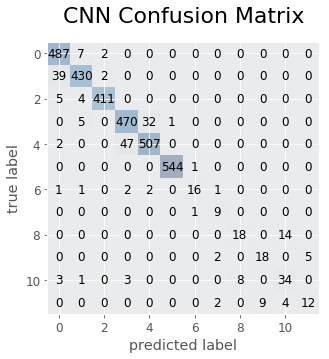

In [203]:
'''cnn_pred_test = model.predict_classes(np.array(X_test),verbose=1, batch_size=200)
font = {'size'   : 12}
plt.rc('font', **font) 
plt.figure(figsize=(100,100))
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test_org[0], cnn_pred_test))
fig.set_size_inches(5, 5)
plt.title('CNN Confusion Matrix',fontsize=22)
plt.show()'''

In [284]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion Matrix Without Normalization
[[474  12  10   0   0   0   0   0   0   0   0   0]
 [ 13 458   0   0   0   0   0   0   0   0   0   0]
 [  3  12 405   0   0   0   0   0   0   0   0   0]
 [  0   8   0 435  64   1   0   0   0   0   0   0]
 [  3   1   0  19 533   0   0   0   0   0   0   0]
 [  0   0   0   0   0 545   0   0   0   0   0   0]
 [  0   2   0   1   2   0  18   0   0   0   0   0]
 [  0   1   0   0   0   0   1   8   0   0   0   0]
 [  0   0   0   0   0   1   0   0  27   0   4   0]
 [  0   0   0   0   0   0   0   0   0  21   0   4]
 [  3   2   0   1   1   1   0   0  10   0  31   0]
 [  0   0   0   0   0   0   0   0   0   8   3  16]]
Normalized Confusion Matrix
[[0.96 0.02 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.03 0.97 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.03 0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.   0.86 0.13 0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.   0.03 0.96 0.   0.   0.   0.   0.   0.   0.  ]
 [0. 

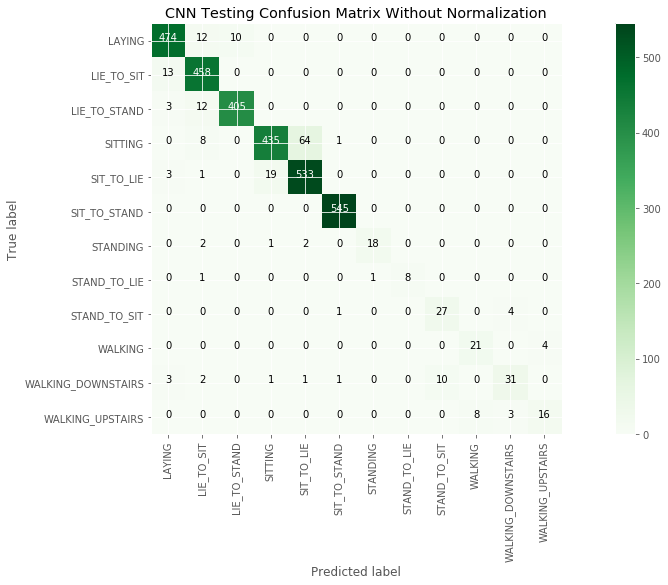

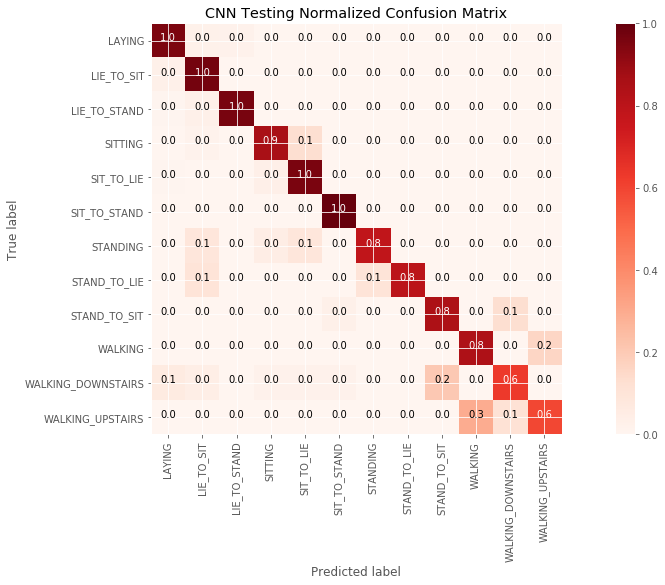

In [285]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_org, cnn_pred_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity,
                      title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity, normalize=True,
                      title='CNN Testing Normalized Confusion Matrix')

plt.show()

Confusion Matrix Without Normalization
[[1223    0    3    0    0    0    0    0    0    0    0    0]
 [   0 1073    0    0    0    0    0    0    0    0    0    0]
 [   0    0  987    0    0    0    0    0    0    0    0    0]
 [   0    0    0 1234   58    1    0    0    0    0    0    0]
 [   0    0    0   34 1389    0    0    0    0    0    0    0]
 [   0    0    0    0    0 1413    0    0    0    0    0    0]
 [   0    4    0    0    1    0   41    0    1    0    0    0]
 [   0    0    0    0    0    0    0   23    0    0    0    0]
 [   0    0    0    0    0    0    0    1   74    0    0    0]
 [   0    0    0    0    0    0    0    0    0   53    0    7]
 [   0    2    0    0    0    2    1    0    8    1   76    0]
 [   0    0    0    0    0    3    0    0    0   12    0   42]]
Normalized Confusion Matrix
[[9.98e-01 0.00e+00 2.45e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+0

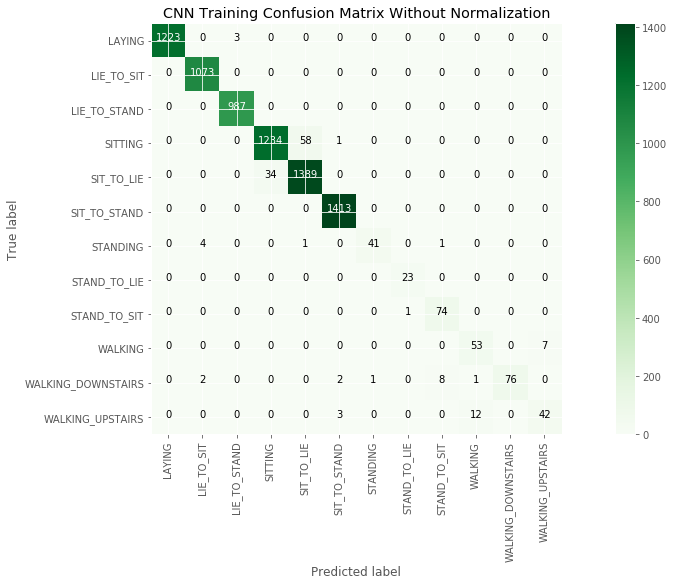

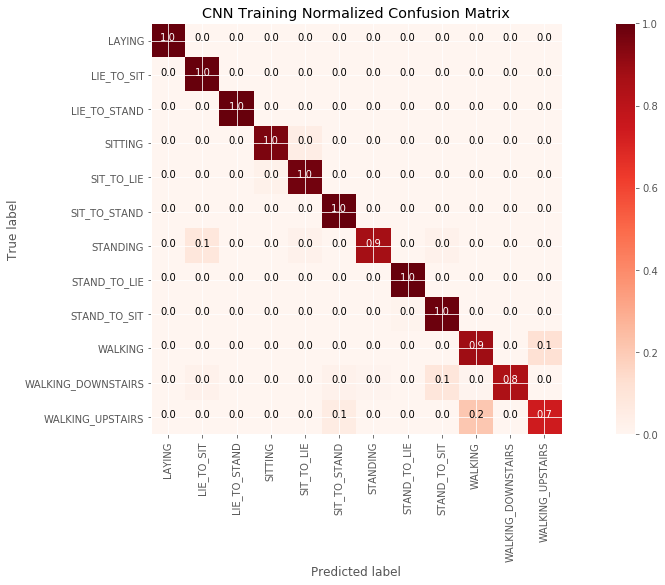

In [286]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train_org, cnn_pred_train)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity,
                      title='CNN Training Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity, normalize=True,
                      title='CNN Training Normalized Confusion Matrix')

plt.show()

Confusion Matrix Without Normalization
[[1413    0    0    0    0    0    0    0    0    0    0    0]
 [   0   60    0    0    0    0    0    0    0    0    0    0]
 [   0    0   57    0    0    0    0    0    0    0    0    0]
 [   0    0    0 1282    0    0   11    0    0    0    0    0]
 [   0    0    0    0   75    0    0    0    0    0    0    0]
 [   0    0    0    0    0   23    0    0    0    0    0    0]
 [   0    0    0   16    0    0 1407    0    0    0    0    0]
 [   0    0    0    0    0    0    0   90    0    0    0    0]
 [   0    0    0    0    0    0    0    0   47    0    0    0]
 [   0    0    0    0    0    0    0    0    0 1226    0    0]
 [   0    0    0    0    0    0    0    0    0    0  987    0]
 [   0    0    0    0    0    0    0    0    0    0    0 1073]]
Normalized Confusion Matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.   0.   0. 

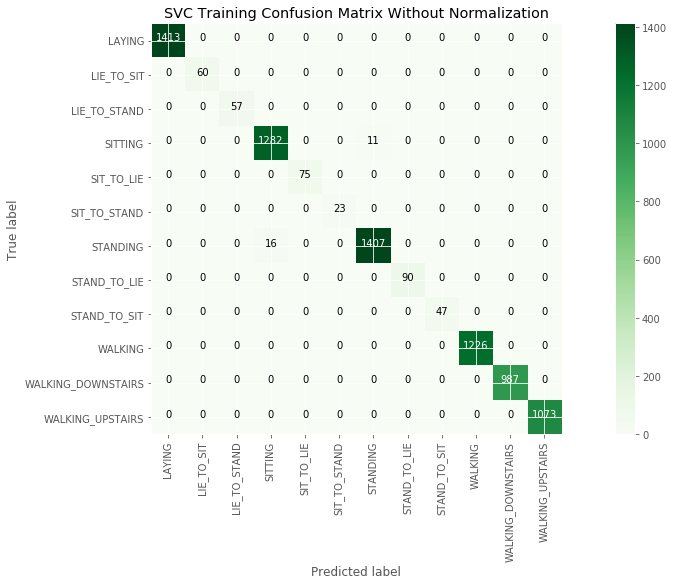

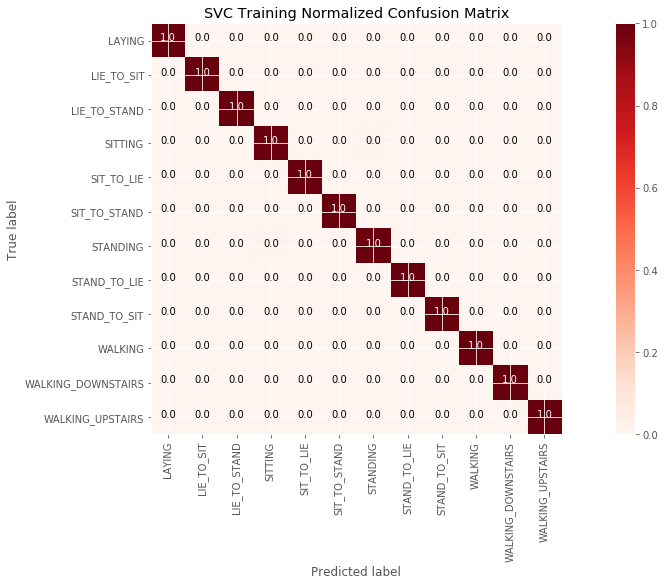

In [287]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, svc_pred_train)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity,
                      title='SVC Training Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity, normalize=True,
                      title='SVC Training Normalized Confusion Matrix')

plt.show()

Confusion Matrix Without Normalization
[[545   0   0   0   0   0   0   0   0   0   0   0]
 [  0  18   7   0   0   0   0   0   0   0   0   0]
 [  0   6  18   0   0   0   0   3   0   0   0   0]
 [  0   0   0 453   0   1  53   0   0   0   0   1]
 [  0   0   0   0  20   0   0  12   0   0   0   0]
 [  0   0   0   0   0  10   0   0   0   0   0   0]
 [  0   0   0  13   0   0 543   0   0   0   0   0]
 [  2   0   0   1  13   0   0  33   0   0   0   0]
 [  0   0   0   2   2   0   0   1  17   0   0   1]
 [  0   0   0   0   0   0   0   0   0 493   3   0]
 [  0   0   0   0   0   0   0   0   0   5 407   8]
 [  0   0   0   0   0   0   0   0   1  15   0 455]]
Normalized Confusion Matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.72 0.28 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.22 0.67 0.   0.   0.   0.   0.11 0.   0.   0.   0.  ]
 [0.   0.   0.   0.89 0.   0.   0.1  0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.62 0.   0.   0.38 0.   0.   0.   0.  ]
 [0. 

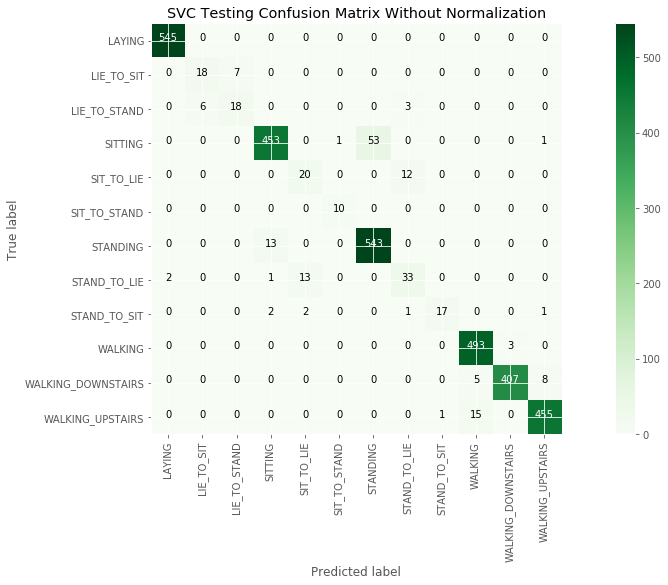

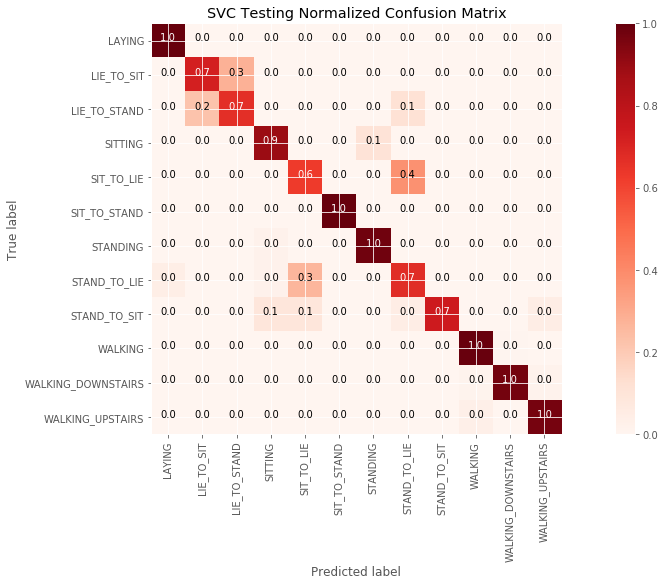

In [288]:
cnf_matrix = confusion_matrix(y_test, svc_pred_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity,
                      title='SVC Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity, normalize=True,
                      title='SVC Testing Normalized Confusion Matrix')

plt.show()

Confusion Matrix Without Normalization
[[474  12  10   0   0   0   0   0   0   0   0   0]
 [ 13 458   0   0   0   0   0   0   0   0   0   0]
 [  3  12 405   0   0   0   0   0   0   0   0   0]
 [  0   8   0 435  64   1   0   0   0   0   0   0]
 [  3   1   0  19 533   0   0   0   0   0   0   0]
 [  0   0   0   0   0 545   0   0   0   0   0   0]
 [  0   2   0   1   2   0  18   0   0   0   0   0]
 [  0   1   0   0   0   0   1   8   0   0   0   0]
 [  0   0   0   0   0   1   0   0  27   0   4   0]
 [  0   0   0   0   0   0   0   0   0  21   0   4]
 [  3   2   0   1   1   1   0   0  10   0  31   0]
 [  0   0   0   0   0   0   0   0   0   8   3  16]]
Normalized Confusion Matrix
[[0.96 0.02 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.03 0.97 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.03 0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.02 0.   0.86 0.13 0.   0.   0.   0.   0.   0.   0.  ]
 [0.01 0.   0.   0.03 0.96 0.   0.   0.   0.   0.   0.   0.  ]
 [0. 

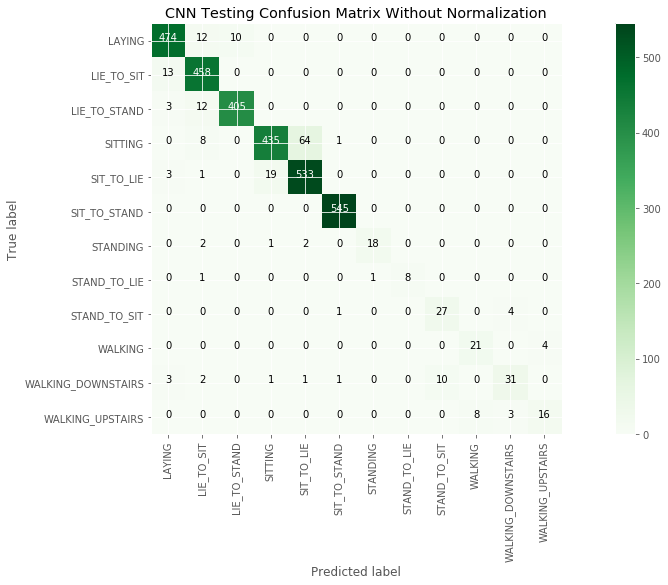

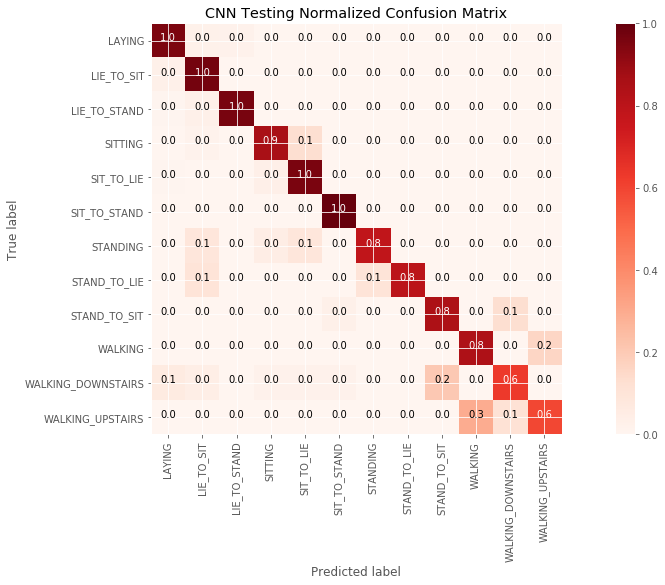

In [289]:
cnf_matrix = confusion_matrix(y_test_org, cnn_pred_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity,
                      title='CNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes= activity, normalize=True,
                      title='CNN Testing Normalized Confusion Matrix')

plt.show()

In [50]:
print("Accuracy Score Comparison\n*************************")
print("Benchmark Model (PCA103)\n------")
print("Training data: {:.3f}".format(accuracy_score(y_train, svc_pred_train103)))
print("Testing data: {:.3f}".format(accuracy_score(y_test, svc_pred_test103)))
print("")
print("SVC (fullset)\n------")
print("Training data: {:.3f}".format(accuracy_score(y_train, svc_pred_train)))
print("Testing data: {:.3f}".format(accuracy_score(y_test, svc_pred_test)))
print("")
print("CNN (fullset)\n------")
print("Training data: {:.3f}".format(train_acc_scores[1]))
print("Testing data: {:.3f}".format(test_acc_scores[1]))

Accuracy Score Comparison
*************************
Benchmark Model (PCA103)
------


NameError: name 'svc_pred_train103' is not defined

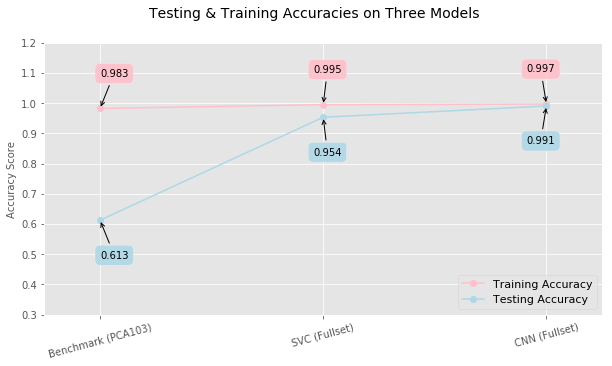

In [342]:

# a plot of the different Testing & Training Accuracies# a plot  
training_accuracies = [accuracy_score(y_train, svc_pred_train103),
                       accuracy_score(y_train, svc_pred_train),
                       train_acc_scores[1]]

testing_accuracies = [accuracy_score(y_test, svc_pred_test103),
                      accuracy_score(y_test, svc_pred_test),
                      test_acc_scores[1]] 

algorithm_list = ['Benchmark (PCA103)', 'SVC (Fullset)', 'CNN (Fullset)']

plt.figure(figsize=(10, 5))

plt.plot(training_accuracies, '-o', color='pink', label='Training Accuracy')
plt.plot(testing_accuracies, '-o', color='lightblue', label='Testing Accuracy')

for i in range(len(testing_accuracies)):
    plt.annotate('{:.3f}'.format(testing_accuracies[i]), 
            xy = (i, testing_accuracies[i]), xytext = (-10 * i , -40),
            textcoords = 'offset points', ha = 'left', va = 'bottom', fontsize=10,
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'lightblue', alpha = 0.9),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0', linewidth=1, color='black'))
    
for i in range(len(training_accuracies)):
    plt.annotate('{:.3f}'.format(training_accuracies[i]), 
            xy = (i, training_accuracies[i]), xytext = (-10 * i , 30),
            textcoords = 'offset points', ha = 'left', va = 'bottom', fontsize=10,
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'pink', alpha = 0.9),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3, rad=0', linewidth=1, color='black'))

plt.ylim(0.3, 1.2)
plt.ylabel('Accuracy Score', fontsize=10)

plt.xlim(-0.25, 2.25)
plt.xticks(range(3), algorithm_list, rotation=15, fontsize=10)

plt.suptitle('Testing & Training Accuracies on Three Models', fontsize=14)
plt.legend(loc = 4, fontsize=11)

plt.show()

#### 5. Sensitivity Analysis

In [73]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train_pca, y_train.values.ravel(), test_size=0.4, random_state=0)

clf_train = SVC(kernel='rbf', C=1000, gamma = 0.001,class_weight='balanced', probability=True).fit(X_train_cv, y_train_cv)
cv_scores = cross_val_score(clf_train, X_train_pca, y_train.values.ravel(), cv=10)
print("Accuracy on training set: %0.4f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy on training set: 0.9447 (+/- 0.08)


In [76]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_test, y_test.values.ravel(), test_size=0.4, random_state=0)

clf_test = SVC(kernel='rbf', C=1000, gamma = 0.001,class_weight='balanced', probability=True).fit(X_test_cv, y_test_cv)
cv_scores = cross_val_score(clf_test, X_test, y_test.values.ravel(), cv=10)
print("Accuracy on testing set: %0.4f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

Accuracy on testing set: 0.9377 (+/- 0.07)
